In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 1. Especificar el ticker de la acción
ticker = 'TSLA' # Aquí puedes poner el ticker que desees, por ejemplo, AAPL para Apple

# 2. Descargar los precios históricos usando yfinance
data = yf.download(ticker, start="2021-01-01", end="2025-08-04")  # Especificamos el rango de fechas

# 3. Visualizar los primeros registros
print(data.head())

In [2]:
ticker = 'TSLA'
data = pd.read_excel(r"C:\github\pj_sa_202601\docs\TSLA.xlsx")

In [3]:
data.tail()

,date,Close,High,Low,Open,Volume
533,2026-02-18,411.320007,416.899994,409.579987,411.109985,45921400
534,2026-02-19,411.709991,415.250000,404.109985,407.250000,51019600
535,2026-02-20,411.820007,414.700012,405.500000,408.299988,57912200
536,2026-02-23,399.829987,407.700012,394.040009,407.290009,69480900
537,2026-02-24,405.554993,407.709991,397.640015,399.549988,25253937


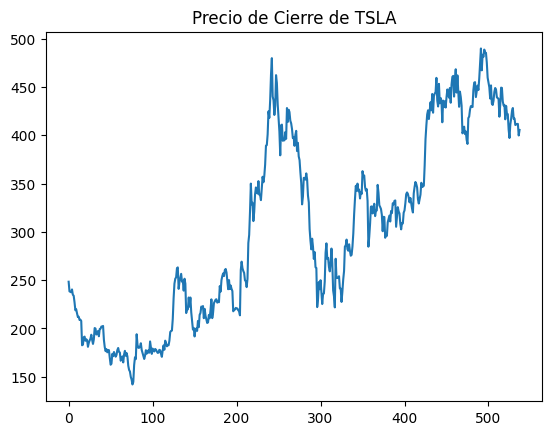

In [4]:
data['Close'].plot(title=f"Precio de Cierre de {ticker}")
plt.show()

In [5]:
#Vemos la estructura de los datos, durante el ultimo año
data[data.date>'2025-01-01'].head()

,date,Close,High,Low,Open,Volume
252,2025-01-02,379.279999,392.730011,373.040009,390.100006,109710700
253,2025-01-03,410.440002,411.880005,379.450012,381.480011,95423300
254,2025-01-06,411.049988,426.429993,401.700012,423.200012,85516500
255,2025-01-07,394.359985,414.329987,390.000000,405.829987,75699500
256,2025-01-08,394.940002,402.500000,387.399994,392.950012,73038800


1. Vamos a emplear para el analisis los precios ajustados al cierre. 
Estos precios son mas realistas, pues consideran la reparticion de dividendos, splits, consolidaciones comporativas etc

# Definicion del Movimiento Browniano Geometrico

Se ha demostrado matematicamente que el comportamiento de las acciones se puede modelar con un MBG.

$$dS(t) = \mu S(t) dt + \sigma S(t) dB(t)$$

donde:
- $S(t)$ es el precio en el tiempo $t$,
- $\mu$ es la tasa de crecimiento esperada,
- $\sigma$ es la volatilidad,
- $B(t)$ es un proceso de Wiener, tambien conocido como ruido aleatorio.

La solución de esta ecuación es:

$$S(t+1) = S(t) \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma B(t)\right)$$



1. Para calcular $\mu$ en primer lugar debemos calcular los retornos logaritmicos para cada momento $t$

$$rt=ln\left(\frac{st}{st-1}\right)$$

In [6]:
data['retornos']=(data['Close'] / data['Close'].shift(1)).apply(lambda x: np.log(x))
data.head()

,date,Close,High,Low,Open,Volume,retornos
0,2024-01-02,248.419998,251.250000,244.410004,250.080002,104654200,NaN
1,2024-01-03,238.449997,245.679993,236.320007,244.979996,121082600,-0.040961
2,2024-01-04,237.929993,242.699997,237.729996,239.250000,102629300,-0.002183
3,2024-01-05,237.490005,240.119995,234.899994,236.860001,92488900,-0.001851
4,2024-01-08,240.449997,241.250000,235.300003,236.139999,85166600,0.012387


2. Calculamos la tasa de crecimiento esperada

$$\mu=\frac{1}{N}\sum_{t=1}^{n} rt$$

In [7]:
#Metodo 1
N=len(data)-1 #Menos 1 porque el primer elemento no tiene retorno
mu=data['retornos'].sum()/N
print('el parametro mu del modelo es: ', mu)

el parametro mu del modelo es:  0.0009127292859802212


In [8]:
#Metodo 2
data['retornos'].mean()

np.float64(0.0009127292859802212)

3. Calculamos la volatilidad $\sigma$

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{t=1}^{N} \left( r_t - \mu \right)^2}$$





In [9]:
#Metodo 1
N = len(data['retornos']) -1 # Número total de retornos
sigma = np.sqrt(np.sum((data['retornos'] - mu)**2) / (N - 1))
print('el parametro sigma del modelo es: ', sigma)

el parametro sigma del modelo es:  0.038700914944764735


In [10]:
#Metodo 2
sigma = data['retornos'].std()
sigma

np.float64(0.038700914944764735)

3. Definimos el proceso estocastico asi:

$$st+1=st*EXP\left[\left(\mu -\frac{\sigma^2}{2}\right)dt+\sigma et \sqrt{dt}\right]\$$

donde,

- dt es 1/252 dias de mercado 
- et es un numero aleatorio de una distribucion N(0,1)
- st retorno en el momento t
- st+1 retorno en el momento t+1

In [11]:
#Procedemos a crear una funcion que modele el proceso estocastico
def MGB_acciones(mu,sigma,data,col_name,steps):

    #Los parametros de la funcion son:
    #mu -> Tasa de crecimiento esperada
    #sigma -> volatilidad del activo
    #data -> pandas df que contiene los retornos logaritmicos del activo en dias
    #col_name -> nombre de la columna de los retornos
    #steps -> numero de pasos hacia adelante en el proceso estocastico

    dt=1/252 # son solo 252 dias de traiding en el año.
    s0=float(data['Close'].iloc[-1]) #Tomamos el ultimo elemento de los precios, ya que este sera el punto de partida
    et_vector=np.random.normal(loc=0, scale=1, size=steps) # Vector de numeros aletorios de media 0 y desviacion estandar 1
    exp_vector = np.exp((mu - (sigma**2) / 2) * dt + sigma * et_vector * np.sqrt(dt))

    st_1=[]

    for i in range(0,steps):

        if i==0:
            s=s0*exp_vector[0]
        else:
            s=st_1[i-1]*exp_vector[i]

        st_1.append(s)
            

    return st_1

#Probamos la funcion
#MGB_acciones(mu, sigma, data, 'Adj Close',252)

In [12]:
# Funcion que realiza graficos de lineas
def lineas_multiples(data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y'):
    """
    Función para graficar múltiples líneas con colores aleatorios.
    
    Parámetros:
    - data: DataFrame de pandas con los datos a graficar.
    - title: Título del gráfico.
    - xlabel: Etiqueta del eje X.
    - ylabel: Etiqueta del eje Y.
    """
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    num_lines = data.shape[1]  # Número de líneas (columnas en el DataFrame)
    
    # Generar un color aleatorio para cada línea
    colors = np.random.rand(num_lines, 3)  # Colores aleatorios en RGB

    for i in range(num_lines):
        plt.plot(np.arange(1, data.shape[0] + 1), data.iloc[:, i], color=colors[i], label=f'Línea {i + 1}')  # Acceso corregido
    
    # Configurar título y etiquetas
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Mostrar la cuadrícula
    plt.grid(True)
    
    # Mostrar leyenda
    #plt.legend()
    
    # Mostrar el gráfico
    plt.show()

In [13]:
sim=500
simulations = []
for i in range(sim):
    s = pd.Series(MGB_acciones(mu, sigma, data, 'Close', 252))
    s.name = f'sim_{i}'
    simulations.append(s)

Montecarlo_results = pd.concat(simulations, axis=1)

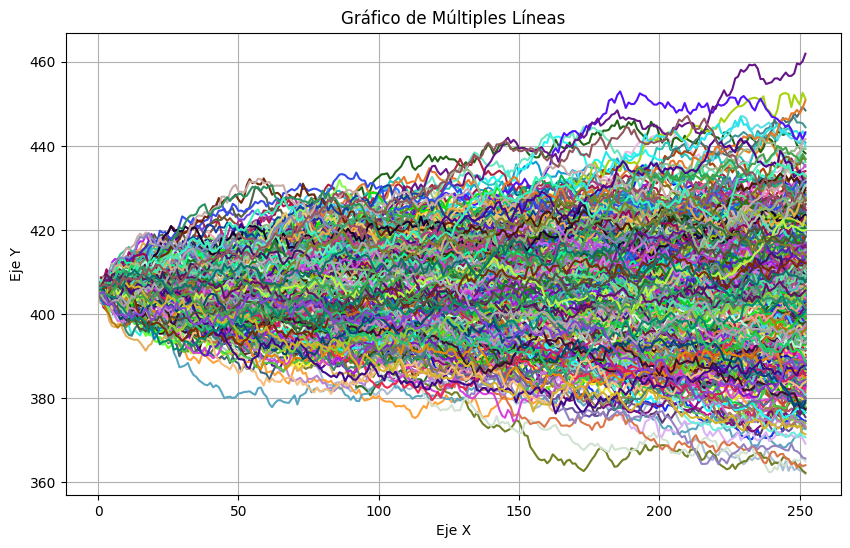

In [14]:
#Graficamos
lineas_multiples(Montecarlo_results, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y')

In [15]:
#Calculamos la probabilidad de perder 5% de la inversion inicial en el próximo año
alfa=0.05
s0=data['Close'].iloc[-1]
print('El precio de compra es: ', s0)

El precio de compra es:  405.5549926757812


In [16]:
Montecarlo_results.tail()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
247,434.701713,423.999537,384.383323,412.555564,416.671713,362.911218,400.827766,413.997120,402.178674,407.294986,...,386.009420,402.716077,418.243924,373.485459,400.566720,437.647926,396.659068,409.223999,426.726473,387.578055
248,435.542916,423.773007,383.313014,410.749386,416.085259,363.354747,400.718420,412.417366,402.605948,407.000982,...,385.461128,403.649691,416.761207,373.195338,399.528949,437.321813,396.231429,409.015784,427.844069,386.894248
249,432.608845,423.951302,385.091537,411.398079,415.249921,362.822026,401.097058,413.313608,401.521467,406.605798,...,387.044620,403.323288,416.872905,373.549004,399.356397,436.221124,395.347522,408.386938,428.987786,388.625475
250,432.779773,424.132701,384.459358,411.945079,415.082732,362.625930,399.662939,415.037894,402.290552,406.310059,...,387.569140,402.564459,416.842820,371.765772,399.802456,438.085894,393.228754,408.678392,428.566626,388.772324
251,432.983265,425.960889,382.419755,412.059207,415.554710,362.066929,398.213115,415.017844,400.754668,406.606648,...,387.927879,401.452429,418.454944,371.460194,400.849223,436.911386,393.263644,407.615789,426.937923,388.121652


In [17]:
precios_cierre = Montecarlo_results.iloc[-1,:] #Seleccionamos los precios finales a un año de inversion
precios_cierre

sim_0      432.983265
sim_1      425.960889
sim_2      382.419755
sim_3      412.059207
sim_4      415.554710
              ...    
sim_495    436.911386
sim_496    393.263644
sim_497    407.615789
sim_498    426.937923
sim_499    388.121652
Name: 251, Length: 500, dtype: float64

In [18]:
total=len(precios_cierre)
exito=len(precios_cierre[precios_cierre<(s0*(1-alfa))])

p=exito/total

print(p*100,'%')

11.4 %


In [19]:
total=len(precios_cierre)
exito=len(precios_cierre[precios_cierre>(s0*(1.1))])
p=exito/total

print(p*100,'%')

0.8 %
